In [1]:
import torch
import pickle
import warnings
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch_geometric.utils import dense_to_sparse
import networkx as nx
from scipy.spatial.distance import cdist

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric.data import Data

In [3]:
# TODO:
# 0 - variável alvo Rain Hourly (mm)
# 1 - Fazer a previsao da variavel (univariada) GRU, LSTM, SARIMA
# 2 - Foundation
# 3 - GNNs
# 3.1 - covariáveis (X: Temp  (°C), Rain Hourly (mm), Speed  (kt), Max Gust Hourly (kt), Clouds, RH  (%), MSL Press  (hPa))


In [4]:
# cols = ['Le_Bons', 'Tauranga_Aerodrome', 'Enderby_Island', 'Cape_Campbell',
#        'Whitianga_Aerodrome', 'Tara_Hills', 'Napier_Aerodrome', 'Hawera_NZHAX',
#        'Secretary_Island', 'Queenstown_Aerodrome', 'Christchurch_Aerodrome',
#        'South_West', 'Invercargill_NZNVA', 'Palmerston_N', 'Oamaru_Aerodrome',
#        'Kaikoura_NZKIX', 'Whanganui_Aerodrome', 'Taupo_Aerodrome',
#        'Hokitika_Aerodrome', 'Nugget_Point', 'Mokohinau_Island', 'Ngawi_NZNWX',
#        'Mt_Cook', 'Cape_Reinga', 'Auckland_Aerodrome', 'Hamilton_Aerodrome',
#        'Wellington_Aerodrome', 'New_Plymouth', 'Haast_NZHTX',
#        'Stephens_Island', 'Milford_Sound', 'Gisborne_Aerodrome',
#        'Puysegur_Point', 'Nelson_Aerodrome', 'Timaru_Airport', 'Hicks_Bay',
#        'Port_Taharoa', 'Farewell_Spit', 'Castlepoint_NZCPX', 'Chatham_Island',
#        'Kerikeri_Aerodrome', 'Raoul_Island', 'Dunedin_Aerodrome',
#        'Whangarei_Aerodrome', 'Kaitaia_Aerodrome', 'Paraparaumu_Aerodrome',
#        'Takapau_Plains', 'Waiouru_Aerodrome', 'Mahia_NZMHX', 'Campbell_Island',
#        'Westport_Aerodrome']

In [5]:
g = nx.read_graphml("../grafo.graphml")

#A = nx.adjacency_matrix(g)
nodes = sorted(g.nodes())  # ou outra lista ordenada de nós
A = nx.adjacency_matrix(g, nodelist=nodes)
a_sparse = A.todense()
A = np.asmatrix(a_sparse)

adj_matrix = A

In [6]:
df = pd.read_parquet("../dataset_temperature_c_interpolation.parquet")
df.head()

,time,Napier_Aerodrome,Wellington_Aerodrome,Enderby_Island,Mokohinau_Island,Cape_Campbell,Westport_Aerodrome,Mahia_NZMHX,Nelson_Aerodrome,Queenstown_Aerodrome,Auckland_Aerodrome,Whanganui_Aerodrome,Farewell_Spit,Kaikoura_NZKIX,Kerikeri_Aerodrome,Castlepoint_NZCPX,Haast_NZHTX,New_Plymouth,Milford_Sound,Whangarei_Aerodrome,Christchurch_Aerodrome,Tara_Hills,Whitianga_Aerodrome,Paraparaumu_Aerodrome,Le_Bons,Waiouru_Aerodrome,Ngawi_NZNWX,Oamaru_Aerodrome,Hokitika_Aerodrome,Stephens_Island,Tauranga_Aerodrome,Raoul_Island,Hamilton_Aerodrome,Hicks_Bay,Timaru_Airport,Taupo_Aerodrome,Puysegur_Point,Chatham_Island,South_West,Hawera_NZHAX,Mt_Cook,Campbell_Island,Invercargill_NZNVA,Port_Taharoa,Palmerston_N,Gisborne_Aerodrome,Nugget_Point,Dunedin_Aerodrome,Cape_Reinga,Secretary_Island,Kaitaia_Aerodrome,Takapau_Plains,split
0,01-Apr-1993 00:00,15.0,17.0,7.0,17.0,11.0,17.0,14.0,15.0,8.0,16.0,16.0,15.0,9.0,15.1,14.0,15.0,14.0,9.0,15.0,14.0,7.0,16.0,14.0,8.0,7.8,14.0,9.0,13.0,18.3,15.0,23.0,16.0,17.0,9.0,13.0,10.0,11.6,8.0,5.8,15.1,12.0,14.0,15.0,14.0,16.0,10.0,8.0,17.0,14.0,16.5,11.4,True
1,01-Apr-1993 01:00,14.0,17.0,7.0,17.0,11.0,16.0,14.0,15.0,8.0,16.0,15.0,15.0,9.0,15.1,14.0,16.0,14.0,9.0,15.0,14.0,7.0,17.0,14.0,8.0,7.8,13.0,9.0,11.0,18.3,15.0,24.0,15.0,17.0,9.0,13.0,9.0,11.6,8.0,5.8,15.1,12.0,14.0,14.0,15.0,15.0,10.0,8.0,16.0,14.0,16.5,11.4,True
2,01-Apr-1993 02:00,14.0,17.0,7.0,17.0,11.0,16.0,15.0,15.0,7.0,15.0,14.0,15.0,10.0,15.1,14.0,16.0,14.0,9.0,15.0,14.0,6.0,15.0,14.0,8.0,7.8,12.0,9.0,12.0,18.3,15.0,24.0,14.0,16.0,9.0,12.0,9.0,11.6,9.0,5.8,15.1,12.0,14.0,14.0,14.0,15.0,10.0,8.0,16.0,14.0,16.5,11.4,True
3,01-Apr-1993 03:00,13.0,17.0,7.0,17.0,11.0,16.0,15.0,14.0,6.0,15.0,15.0,15.0,9.0,15.1,14.0,15.0,14.0,9.0,14.0,14.0,7.0,14.0,13.0,8.0,7.8,11.0,9.0,13.0,18.3,14.0,24.0,14.0,16.0,8.0,11.0,8.0,11.6,8.0,5.8,15.1,12.0,14.0,15.0,14.0,14.0,10.0,8.0,16.0,14.0,16.5,11.4,True
4,01-Apr-1993 04:00,13.0,17.0,7.0,17.0,11.0,15.0,15.0,14.0,7.0,15.0,15.0,14.0,9.0,15.1,14.0,15.0,14.0,9.0,14.0,14.0,7.0,13.0,13.0,8.0,7.8,11.0,9.0,13.0,18.3,15.0,24.0,15.0,16.0,8.0,10.0,8.0,11.6,8.0,5.8,15.1,12.0,14.0,15.0,14.0,14.0,10.0,8.0,16.0,14.0,16.5,11.4,True


In [7]:
adj_osrm = pd.read_csv('../matriz_adjacencia.csv')

In [8]:
train_data = df.query(" split == True")[nodes].values[-1000:]
test_data  = df.query(" split == False ")[nodes].values[:500]
train_data.shape, test_data.shape

((1000, 51), (500, 51))

In [9]:
# organizar as colunas como esta a matriz e adjacencia

In [10]:
node = 25

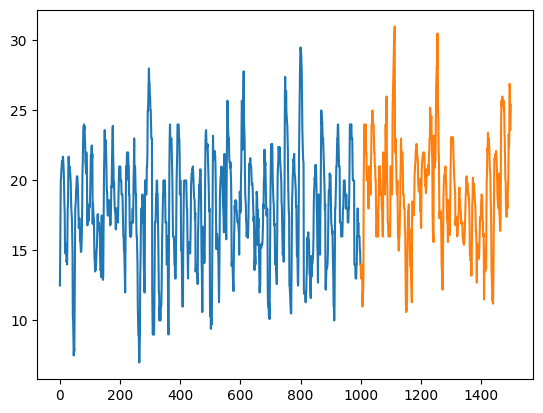

In [11]:
plt.plot(np.arange(0, train_data.shape[0]), train_data[:,node])
plt.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+test_data.shape[0]), test_data[:,node])
plt.show()

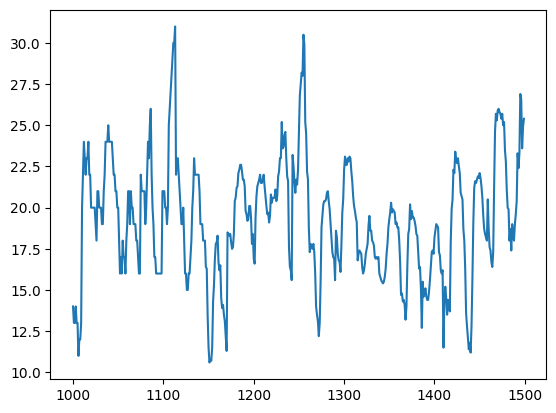

In [12]:
# plt.plot(np.arange(0, train_data.shape[0]), train_data[:,node])
plt.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+test_data.shape[0]), test_data[:,node])
plt.show()

In [13]:
train_data.shape

(1000, 51)

## Node Features

In [14]:
X_torch_train = torch.from_numpy(train_data.T)
X_torch_test  = torch.from_numpy(test_data.T)
X_torch_train.shape, X_torch_test.shape

(torch.Size([51, 1000]), torch.Size([51, 500]))

## Edges

In [15]:
A_torch = torch.from_numpy(A)
edge_indices, values = dense_to_sparse(A_torch)
edge_indices

tensor([[ 0,  0,  0,  ..., 50, 50, 50],
        [ 1,  2,  3,  ..., 47, 48, 49]])

In [16]:
edges = edge_indices
edge_weights = values.float()

In [17]:
## Structure temporal data

In [18]:
X_torch_train.shape

torch.Size([51, 1000])

In [19]:
c = X_torch_train.shape[0]
nlags = 100
n_steps = 100
datas = []
for item in range(X_torch_train.shape[1]-(nlags+n_steps)):
    data = Data(
        
        x = torch.tensor(X_torch_train[:, item:item+nlags].type(torch.float32)),      
        edge_index = edges,   
        edge_attr = edge_weights,

        y = torch.tensor(X_torch_train[:, item+nlags:item+nlags+n_steps].type(torch.float32)),
    )
    datas.append(data)

In [20]:
datas_test = []
for item in range(X_torch_test.shape[1]-(nlags+n_steps)):
    data = Data(
        x = torch.tensor(X_torch_test[:, item:item+nlags].type(torch.float32)),     
        edge_index = edges,  
        edge_attr = edge_weights,
        y = torch.tensor(X_torch_test[:, item+nlags:item+nlags+n_steps].type(torch.float32)),
    )
    datas_test.append(data)

In [21]:
with open(f'dataset_train_{c}_time.pkl', 'wb') as f:
    pickle.dump(datas, f)

In [22]:
with open(f'dataset_test_{c}_time.pkl', 'wb') as f:
    pickle.dump(datas_test, f)

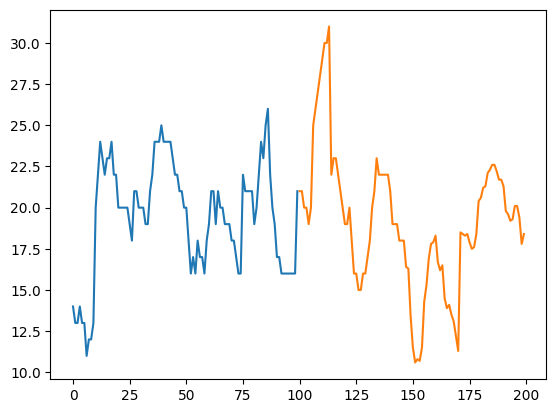

In [27]:
size_x = datas_test[0].x[25,].shape[0]
size_y = datas_test[0].y[25,].shape[0]
plt.plot(np.arange(0, size_x), datas_test[0].x[25,])
plt.plot(np.arange(size_x, size_x + size_y), datas_test[0].y[25,])
plt.show()